In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from methods.normal_map_integration import *
import cv2
from methods.photos_to_stokes import polarization_degree_to_reflection_angle
from scipy.ndimage import gaussian_filter
from matplotlib import cm
import mplcatppuccin
import matplotlib as mpl
from scipy.optimize import newton
mpl.style.use("latte")
import pandas as pd

### Загрузка изображений

Загрузим изображения и вычислим распределение парметров Стокса на фотографии. Это поможет нам вычислить распределение степени и угла поляризации

In [110]:
def visualize_polarization_distribution(polarization: dict):
    fig, ax  = plt.subplots(1, 3, figsize = (18, 7), dpi = 300)
    ax[0].imshow(polarization['s0'], cmap = cm.Spectral)
    ax[0].set_title("S0", fontsize = 16)
    dop = ax[1].imshow(polarization['linear_polarizatioin_degree'], cmap = cm.jet)
    ax[1].set_title("Степень поляризации")
    plt.colorbar(dop, ax = ax[1])
    aop = ax[2].imshow(polarization['angle_of_polarization'], cmap = cm.rainbow)
    plt.colorbar(aop, ax = ax[2])
    ax[2].set_title("Угол поляризации")
    fig.tight_layout()

stokes_parametrs = [[0.5, 0.5, 0.5, 0.5],
                    [1, -1, 0, 0],
                    [0, 0, 1, -1]]
def polarization(polarization_0: np.ndarray,
                 polarization_90: np.ndarray,
                 polarization_45: np.ndarray,
                 polarization_135: np.ndarray) -> dict:
    """Рассчитавает степень и угол поляризации каждого пикселя

    Args:
        polarization_0 (np.ndarray): фотография через поляроид 
        polarization_90 (np.ndarray): фотография через поляроид, скрещенный к исходному
        polarization_45 (np.ndarray): фотография через поляроид с осью под 45 к исходному
        polarization_135 (np.ndarray): фотография через поляроид с осью под 135 к исходному

    Returns:
        dict: Степень поляризации и угол поляризации каждого из пикселей
    """
    global stokes_parametrs
    if len(polarization_0.shape) - 2:
        pass
    intensity_matrix = np.array([polarization_0,  
                                 polarization_90,  
                                 polarization_45,  
                                 polarization_135],
                                 dtype = np.float64)
    s = np.tensordot(stokes_parametrs, intensity_matrix, axes = 1) 
    dolp = np.sqrt(np.power(s[1], 2) + np.power(s[2], 2)) / (s[0] + 1e-4)
    aop = 0.5 * np.angle(s[1] + 1j * s[2])
    return {'linear_polarizatioin_degree': dolp,
            'angle_of_polarization': aop,
            's0': s[0],
            's1': s[1],
            's2': s[2]}
def threshold_black(res: dict, polarization_0, polarization_45, polarization_135, polarization_90, thr = 20) -> dict:
    max_intensity = np.stack([polarization_0, polarization_45, polarization_135, polarization_90], axis = 2)
    max_intensity = np.min(max_intensity, axis = 2)
    res['linear_polarizatioin_degree'] = (max_intensity > thr) * res['linear_polarizatioin_degree']

In [90]:
polarization_0 = cv2.imread("lal/kastrulyasvetodiod_ddfgd/polarization_0.jpg", cv2.IMREAD_GRAYSCALE)[:300, :500]
polarization_45 = cv2.imread("lal/kastrulyasvetodiod_ddfgd/polarization_45.jpg", cv2.IMREAD_GRAYSCALE)[:300, :500]
polarization_90 = cv2.imread("lal/kastrulyasvetodiod_ddfgd/polarization_90.jpg", cv2.IMREAD_GRAYSCALE)[:300, :500]
polarization_135 = cv2.imread("lal/kastrulyasvetodiod_ddfgd/polarization_135.jpg", cv2.IMREAD_GRAYSCALE)[:300, :500]
print(polarization_135.shape)

(300, 500)


In [4]:
# polarization_0 = cv2.bitwise_not(polarization_0)
# polarization_45 = cv2.bitwise_not(polarization_45)
# polarization_90 = cv2.bitwise_not(polarization_90)
# polarization_135 = cv2.bitwise_not(polarization_135)

In [5]:

def scale(val, src, dst):
    """
    Scale the given value from the scale of src to the scale of dst.
    """
    return ((val - src[0]) / (src[1]-src[0])) * (dst[1]-dst[0]) + dst[0]

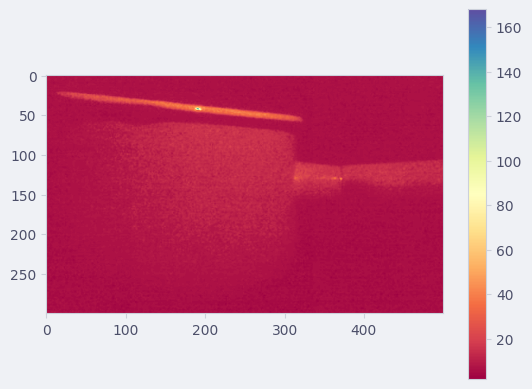

In [91]:
im = plt.imshow(polarization_45, cmap='Spectral')
plt.colorbar(im)

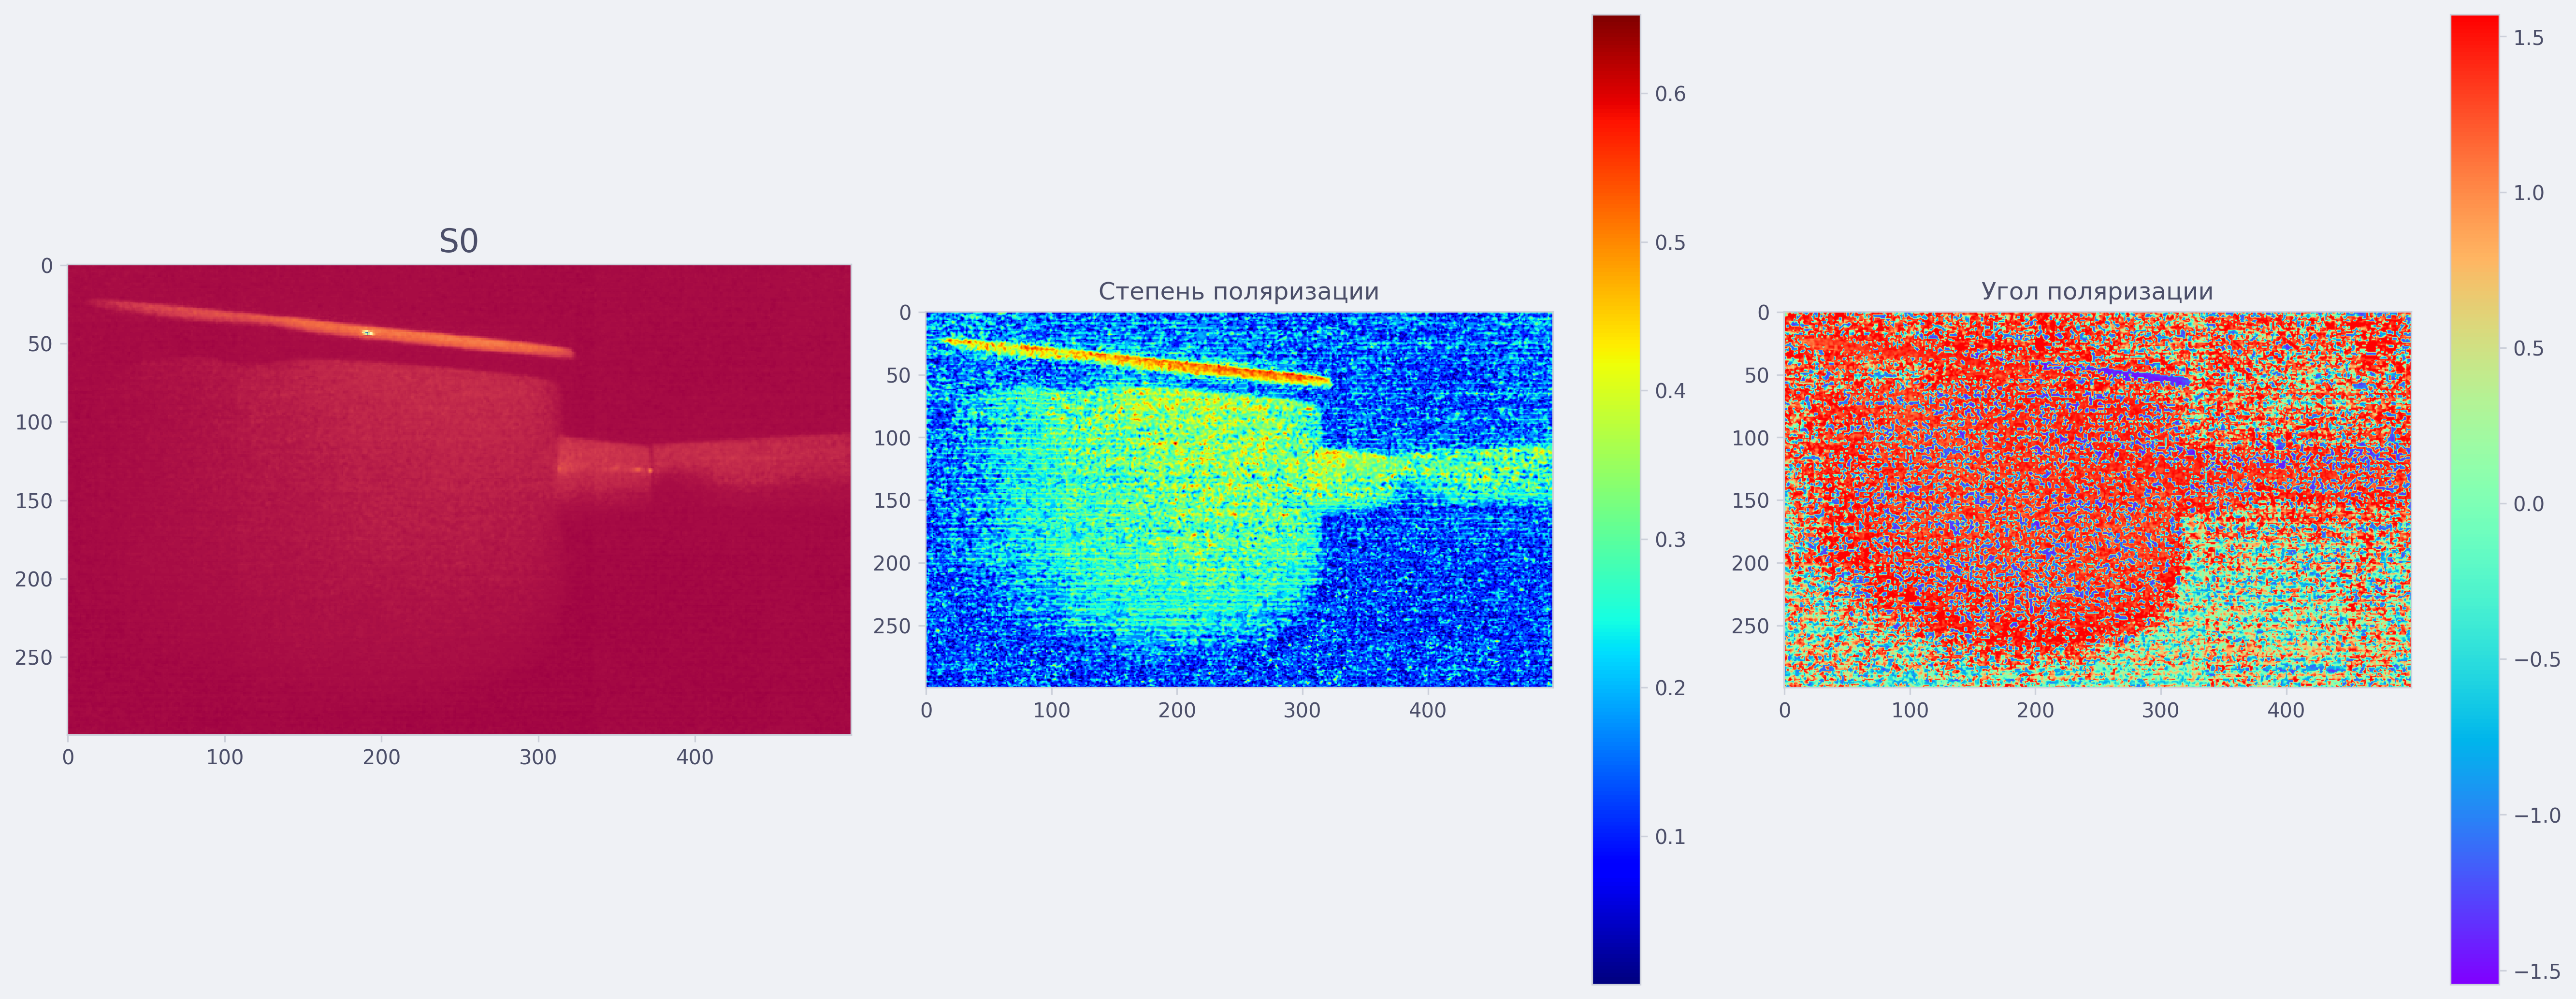

In [111]:
res = polarization(polarization_0 = polarization_0, 
                   polarization_135 = polarization_135,
                   polarization_45 = polarization_45,
                   polarization_90 = polarization_90)
# res['linear_polarizatioin_degree'] = scale(res['linear_polarizatioin_degree'], [0, 1], [1, 0])
#threshold_black(res, polarization_0, polarization_45, polarization_135, polarization_90, thr = 70)
res['linear_polarizatioin_degree'] = gaussian_filter(res['linear_polarizatioin_degree'], sigma = 0.4)
res['angle_of_polarization'] = gaussian_filter(res['angle_of_polarization'], sigma = 0.4)

# res['linear_polarizatioin_degree'] /= np.max(res['linear_polarizatioin_degree'])
visualize_polarization_distribution(res)

### Рассчёт карты нормалей

In [93]:
def deffuse_polarization_degree(theta: np.ndarray, n: float = 1.7) -> np.ndarray:
    """Зависимость степени поляризации от угла отражения

    Args:
        theta (np.ndarray): Угол отражения
        n (float, optional): Показатель преломления. Defaults to 1.7.

    Returns:
        np.ndarray: Степень поляризации
    """
    numerator = np.power(n - 1 / n, 2) * np.power(np.sin(theta), 2)
    denominator = 2 + 2 * np.power(n, 2) - np.power(n + 1 / n, 2) * np.power(np.sin(theta), 2) + 4 * np.cos(theta) * np.sqrt(np.power(n, 2) - np.power(np.sin(theta), 2))
    return numerator / denominator
def polarization_degree_to_reflection_angle_diffuse(dolp: np.ndarray, n: float = 1.7) -> np.ndarray:
    """Функция, обратная к `diffuse_polarization_degree`. Рассчет угла отражения по степени поляризации.

    Args:
        dolp (np.ndarray): Степень поляризации
        n (float, optional): Показатель преломления. Defaults to 1.7.

    Returns:
        np.ndarray: Угол отражения
    """
    temp = np.sqrt((2 * dolp + 2 * n**2 * dolp - 2 * n**2 + n**4 + dolp**2 + 4 * n**2 * dolp**2 - n**4 * dolp**2 - 4 * n**3 * dolp * np.sqrt(-(dolp - 1) * (dolp + 1))) + 1) / np.sqrt(n**4 * dolp**2 + 2 * n**4 * dolp + n**4 + 6 * n**2 * dolp**2 + 4 * n**2 * dolp - 2 * n**2 + dolp**2 + 2 * dolp + 1)
    temp = np.minimum(np.real(temp), 1)
    theta_val = np.arccos(temp)
    return theta_val
def r_perp(phi, n = 1.5):
    psi = np.arcsin(np.sin(phi) / n)
    return (np.cos(phi) - n * np.cos(psi)) / (np.cos(phi) + n * np.cos(psi))
def r_parr(phi, n = 1.5):
    psi = np.arcsin(np.sin(phi) / n)
    return (n * np.cos(phi) - np.cos(psi)) / (n * np.cos(phi) + np.cos(psi))
def d_perp(phi, n = 1.5):
    psi = np.arcsin(np.sin(phi) / n)
    return 2 * np.cos(phi) / (np.cos(phi) + n * np.cos(psi))
def d_parr(phi, n = 1.5):
    psi = np.arcsin(np.sin(phi) / n)
    return 2 * np.cos(phi) / (n * np.cos(phi) + np.cos(psi))
def degree_of_polarization_specular(phi, n):
    return np.abs((np.power(r_parr(phi, n), 2) - np.power(r_perp(phi, n), 2)) / (np.power(r_parr(phi, n), 2) + np.power(r_perp(phi, n), 2)))
def polarization_degree_to_reflection_angle_specular(dolp: np.ndarray, n: float = 1.7):
    angle_zero = polarization_degree_to_reflection_angle_diffuse(dolp, n = n)
    result = np.zeros_like(dolp)
    a = 0
    for i in range(dolp.shape[0]):
        for j in range(dolp.shape[1]):
            f = lambda phi: degree_of_polarization_specular(phi, n) - dolp[i, j]
            try:
                result[i, j] = newton(f, x0 = angle_zero[i, j], tol = 1e-4, maxiter = 400)
            except:
                a+=1
                result[i, j] = 0
    print(a)
    return result

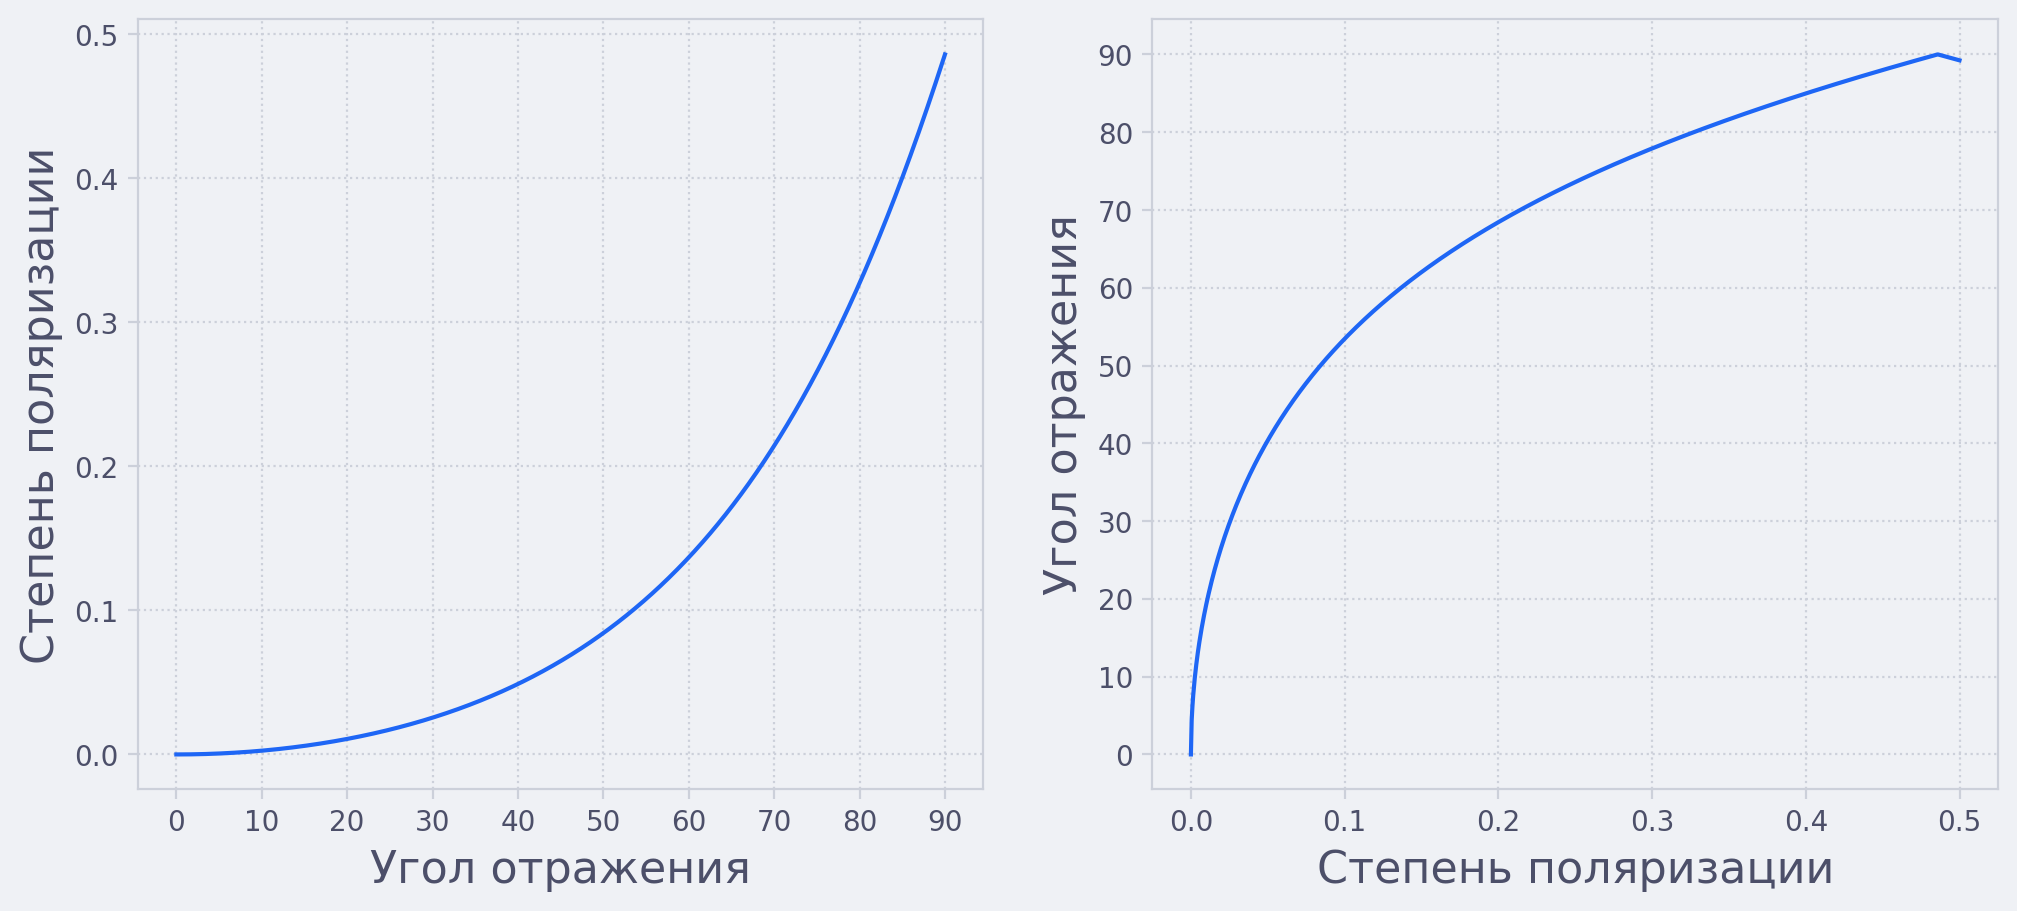

In [94]:
theta_val = np.linspace(0, np.pi / 2, 1000)
dolp = np.linspace(0, 0.5, 1000)

fig, ax = plt.subplots(1, 2, figsize = (12, 5), dpi = 200)
ax[0].plot(theta_val * 180 / np.pi, deffuse_polarization_degree(theta_val))
ax[0].grid(ls = ':')
ax[0].set_xticks(np.arange(0, 100, 10))
ax[0].set_xlabel("Угол отражения", fontsize = 16)
ax[0].set_ylabel("Степень поляризации", fontsize = 16)

ax[1].plot(dolp, polarization_degree_to_reflection_angle_diffuse(dolp) * 180 / np.pi)
ax[1].set_yticks(np.arange(0, 100, 10))
ax[1].set_ylabel("Угол отражения", fontsize = 16)
ax[1].set_xlabel("Степень поляризации", fontsize = 16)
ax[1].grid(ls = ':')

Найдём распределение угла отражения на нашей фотографии. Согласно источнику [Википедия](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%BE%D0%B7%D1%80%D0%B0%D1%87%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B5%D1%80%D0%B0%D0%BC%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%BC%D0%B0%D1%82%D0%B5%D1%80%D0%B8%D0%B0%D0%BB%D1%8B), коэффициент преломления керамики $n = 2.08$. Будем использовать это значение.

##### Использование только диффузного отражения

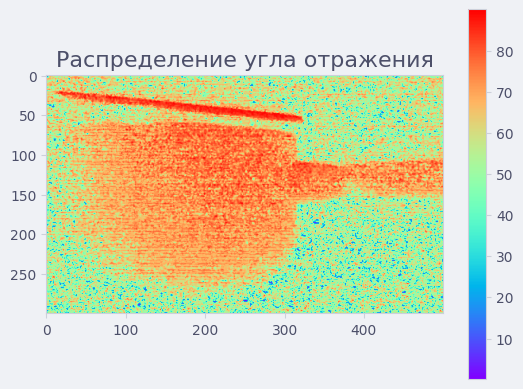

In [95]:
n_ceramics = 1.9
theta = polarization_degree_to_reflection_angle(res['linear_polarizatioin_degree'], n = n_ceramics)
im = plt.imshow(theta * 180 / np.pi, cmap = cm.rainbow)
plt.colorbar(im)
plt.title("Распределение угла отражения", fontsize = 16);

##### Использование и диффузного и зеркального отражения

Будем принимать угол найденный при помощи функци `polarization_degree_to_reflection_angle_diffuse` за начальное приближение для метода Ньютона. Метод Нютона найдет наилучшиий корень для случая зеркального отражения

In [11]:
def angle_to_normal_range(angle):
    return np.arctan2(np.sin(angle), np.cos(angle))

In [12]:
# n_ceramics = 1.3
# theta = polarization_degree_to_reflection_angle_specular(res['linear_polarizatioin_degree'], n = n_ceramics)
# theta = angle_to_normal_range(theta)
# im = plt.imshow(theta, cmap = cm.rainbow)
# plt.colorbar(im)
# plt.title("Распределение угла отражения", fontsize = 16);

##### Найдём карту нормалей:
$$
\begin{pmatrix}
n_{x} \\
n_{y} \\
n_{z} 
\end{pmatrix} = 
\begin{pmatrix}
cos(\phi) sin(\theta) \\
sin(\phi) sin(\theta) \\
cos(\theta)
\end{pmatrix} \propto
\begin{pmatrix}
cos(\phi) tg(\theta) \\
sin(\phi) tg(\theta) \\
1
\end{pmatrix} 
$$

$\phi$ - угол поляризации, $\theta$ - угол отражения

In [69]:

normal_map = np.array([np.sin(theta) * np.cos(res['angle_of_polarization']+ np.pi / 2) / (np.cos(theta) + 1e-6),
                       np.sin(theta) * np.sin(res['angle_of_polarization']+ np.pi / 2) / (np.cos(theta) + 1e-6),
                       np.ones_like(theta)]).T
normal_map = np.swapaxes(normal_map, 0, 1)
normal_map /= np.linalg.norm(normal_map, ord = 2, keepdims = True, axis = 2)
normal_map = (np.cos(theta) > 1e-2)[:, :, np.newaxis] * normal_map
# low_dolp = res['linear_polarizatioin_degree'] < 1e-2
# normal_map[low_dolp] = np.zeros(3) 
cv2.imwrite('normal_map.png', normal_map * 255)
cv2.imwrite('mask.png', np.ones_like(normal_map) * 255)


True

### Восстановление карты высот по найденной карте нормалей

Будем использовать алгоритм, реализованный в файле `methods/normal_map_integration.py`. 

Пусть карта нормалей задана двумя функциями - $p(x, y), q(x, y)$:

$$
\vec{n}(x, y) = (p(x, y), q(x, y), 1)^{T}
$$

Как известно из матматического анализа, нормаль к явно заданной поверхности $z = f(x, y)$ есть
$$
(-\frac{\partial f}{\partial x}, -\frac{\partial f}{\partial y}, 1)^{T}
$$

Таким образом, логично искать карту высот(функцию $f$), которая минимизирует ошибку:
$$
E = \iint\limits_{изображение} \left(\frac{\partial f}{\partial x}(x, y) + p(x, y) \right)^{2} + \left(\frac{\partial f}{\partial y}(x, y) + q(x, y) \right)^{2} d x d y
$$

Оказывается, что Фурье-образ наилучшей функции $f$(для которой $E$ минимальна) связан с Фурье образами функций $p$ и $q$:
$$
\hat{F} = \frac{i u P(u, v) + i v Q(u, v)}{(u + v)^{2}}
$$


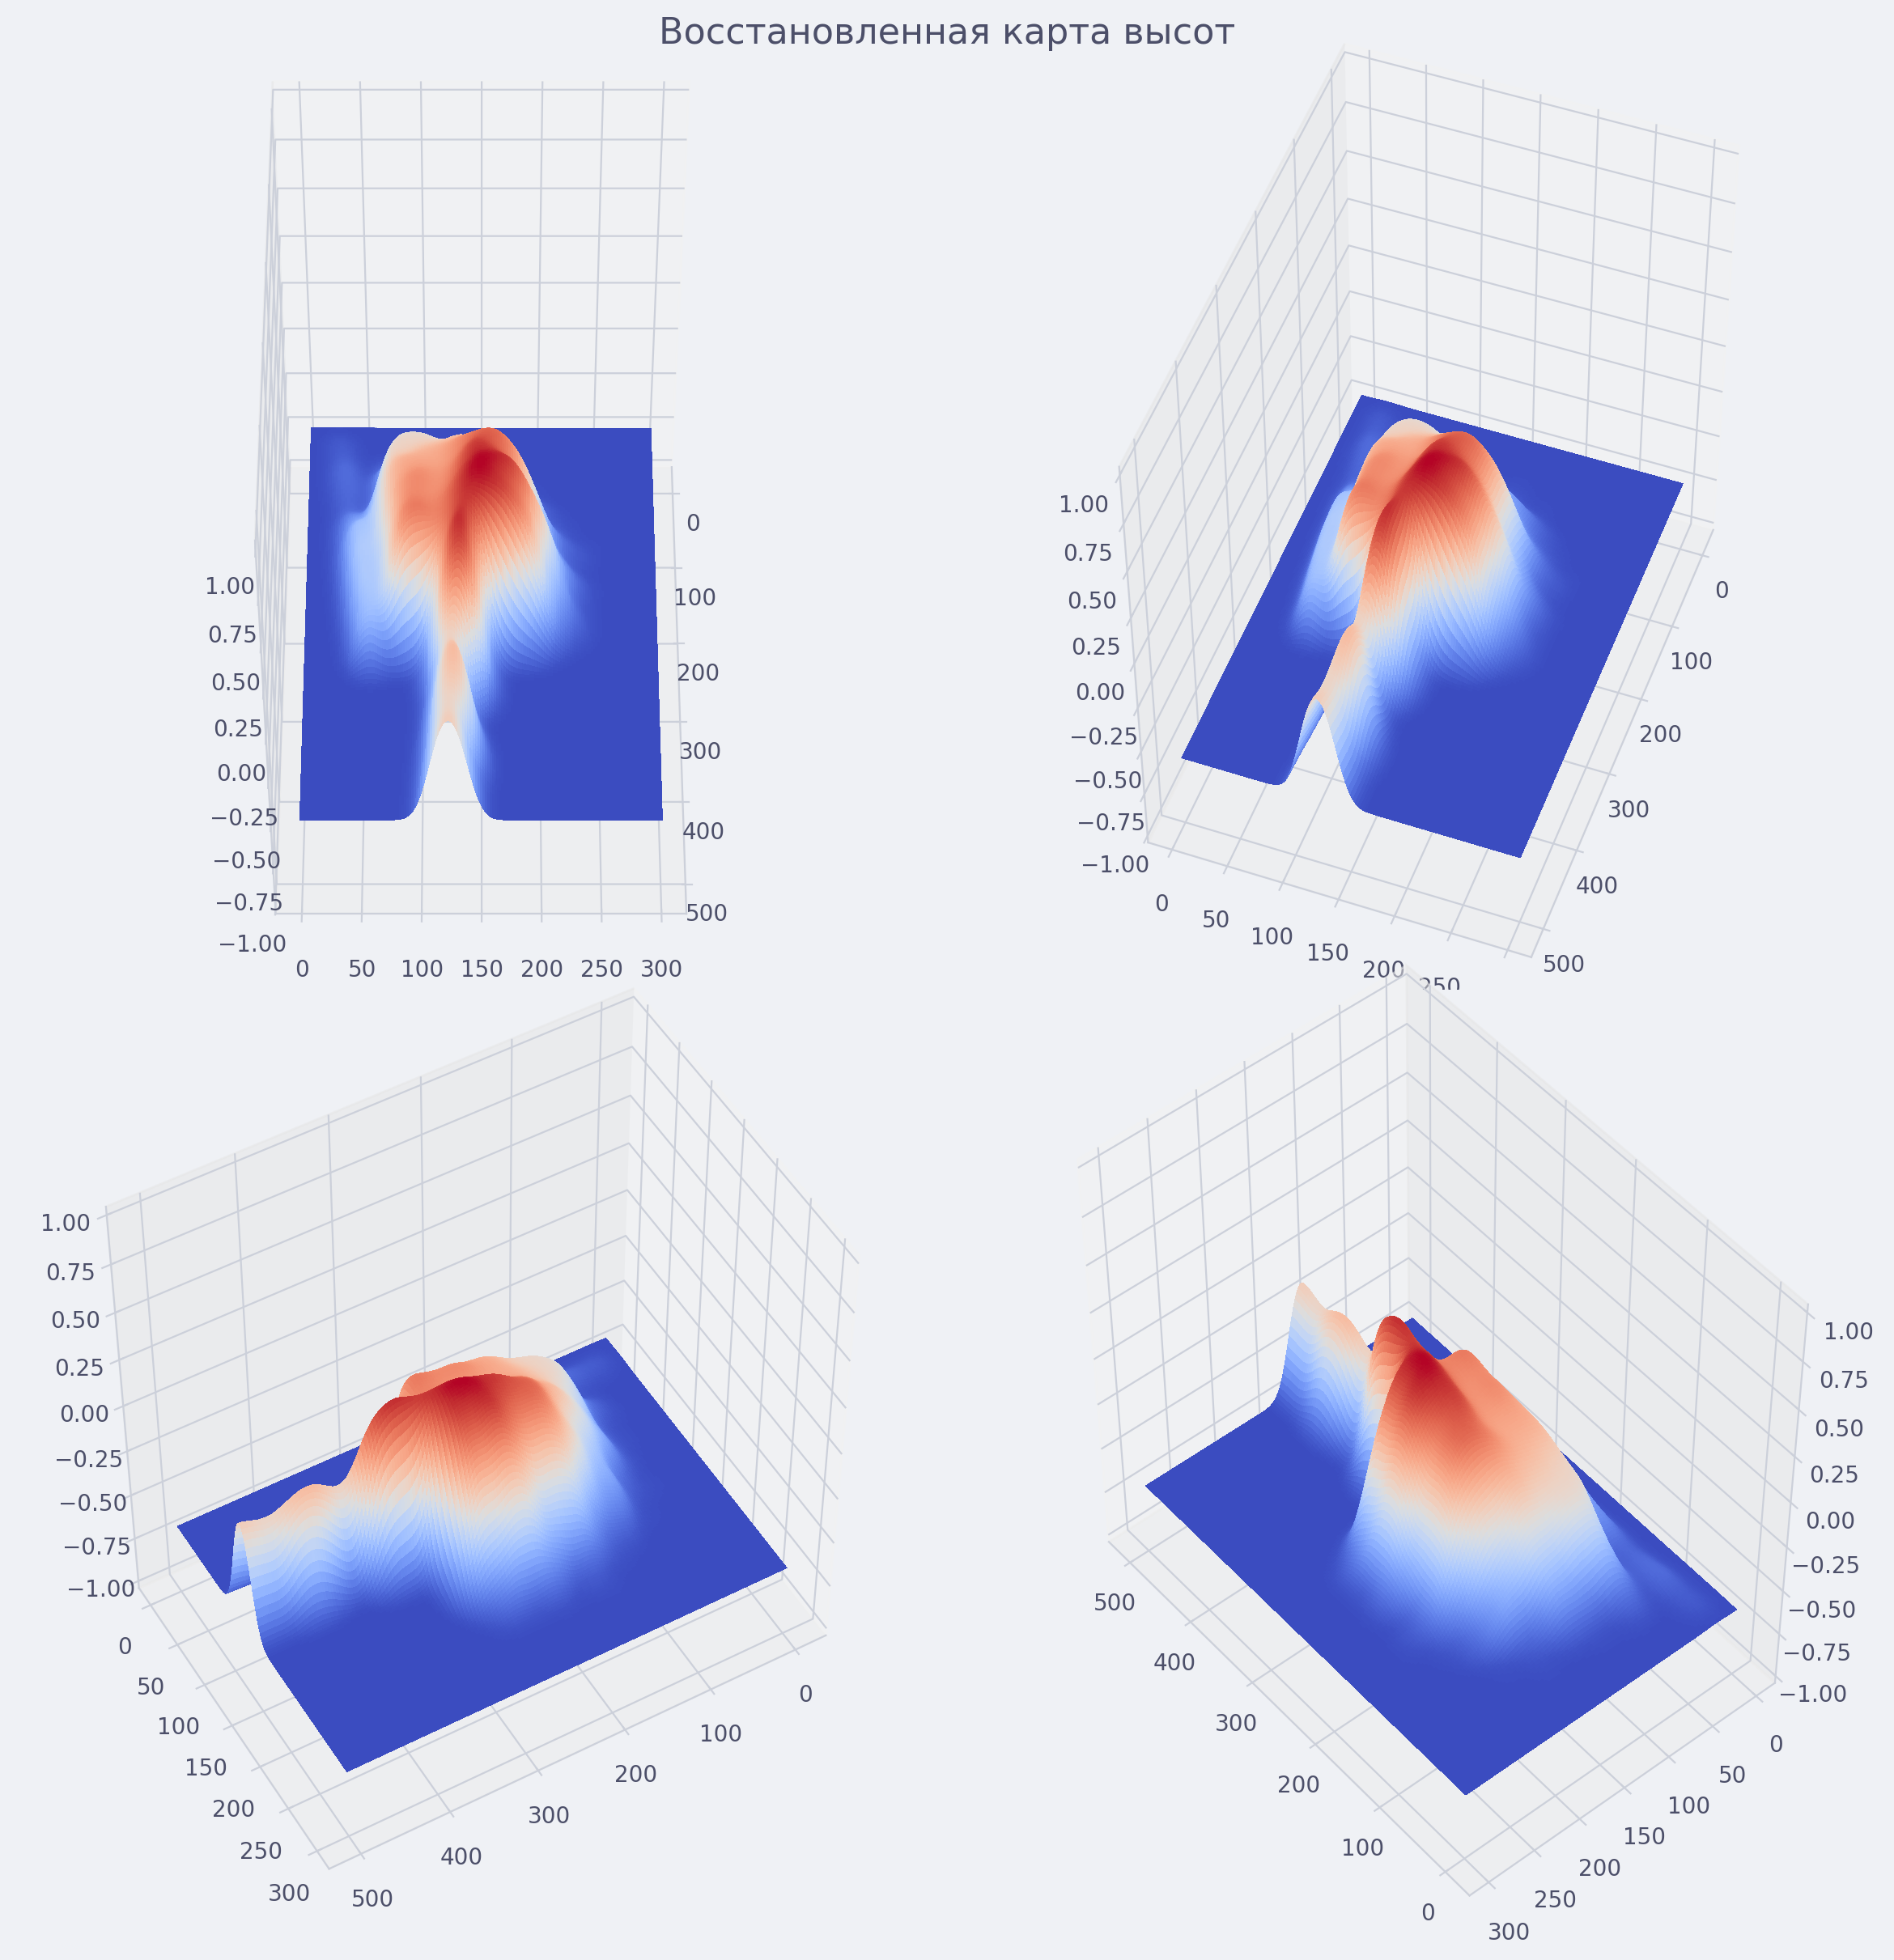

In [112]:
n_ceramics = 1.5
theta = polarization_degree_to_reflection_angle(res['linear_polarizatioin_degree'], n = n_ceramics)
normal_map = np.array([np.sin(theta) * np.cos(res['angle_of_polarization']+ np.pi / 2) / (np.cos(theta) + 1e-6),
                       np.sin(theta) * np.sin(res['angle_of_polarization']+ np.pi / 2) / (np.cos(theta) + 1e-6),
                       np.ones_like(theta)]).T
normal_map = np.swapaxes(normal_map, 0, 1)
normal_map /= np.linalg.norm(normal_map, ord = 2, keepdims = True, axis = 2)
normal_map = (np.cos(theta) > 1e-2)[:, :, np.newaxis] * normal_map
depth_map = normal_map_least_square_integration(normal_map)
depth_map /= np.max(np.abs(depth_map))
mask = res['linear_polarizatioin_degree'] < 1e-5 * 5 
x, y = np.arange(depth_map.shape[1]), np.arange(depth_map.shape[0])
X, Y = np.meshgrid(x, y)
Z = np.copy(depth_map)
Z[mask] = 0
black_mask = polarization_45 < 10
Z[black_mask] = np.min(Z[np.logical_not(black_mask)])
Z = gaussian_filter(Z, sigma = 10)
fig = plt.figure(figsize = (12, 12), dpi = 200)
angles = [0, 20, 60, 140]
for i, a in enumerate(angles): 
    ax = fig.add_axes(int(f'22{i + 1}'), projection = '3d')
    ax.plot_surface(X, Y, Z, antialiased = False, cmap = cm.coolwarm, rcount = 200, ccount = 200)
    ax.view_init(50, a, 0)
    ax.set_box_aspect([1, 0.7, 1])
    ax.set_zlim(-1, 1)

fig.suptitle("Восстановленная карта высот", fontsize = 16)
fig.tight_layout()

In [15]:
# from matplotlib import animation
# fig = plt.figure(figsize = (10, 10))
# ax = fig.add_axes(111, projection = '3d')
# print(depth_map.shape)

# def init():
#     ax.plot_surface(X, Y, Z, antialiased = True, cmap = cm.coolwarm)
#     ax.view_init(40, 60, 0)
#     ax.set_box_aspect([1,0.5,0.5])
#     return fig,

# def animate(i):
#     ax.view_init(elev=60., azim=i)
#     return fig,

# # Animate
# init() 
# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=360, interval=20, blit=True)
# # Save
# anim.save('forshok_veritsya.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

### Определение <<точности>> скана

Cравни экспериментально полученную зависимость высоты с реальной(с видом горшка сбоку).

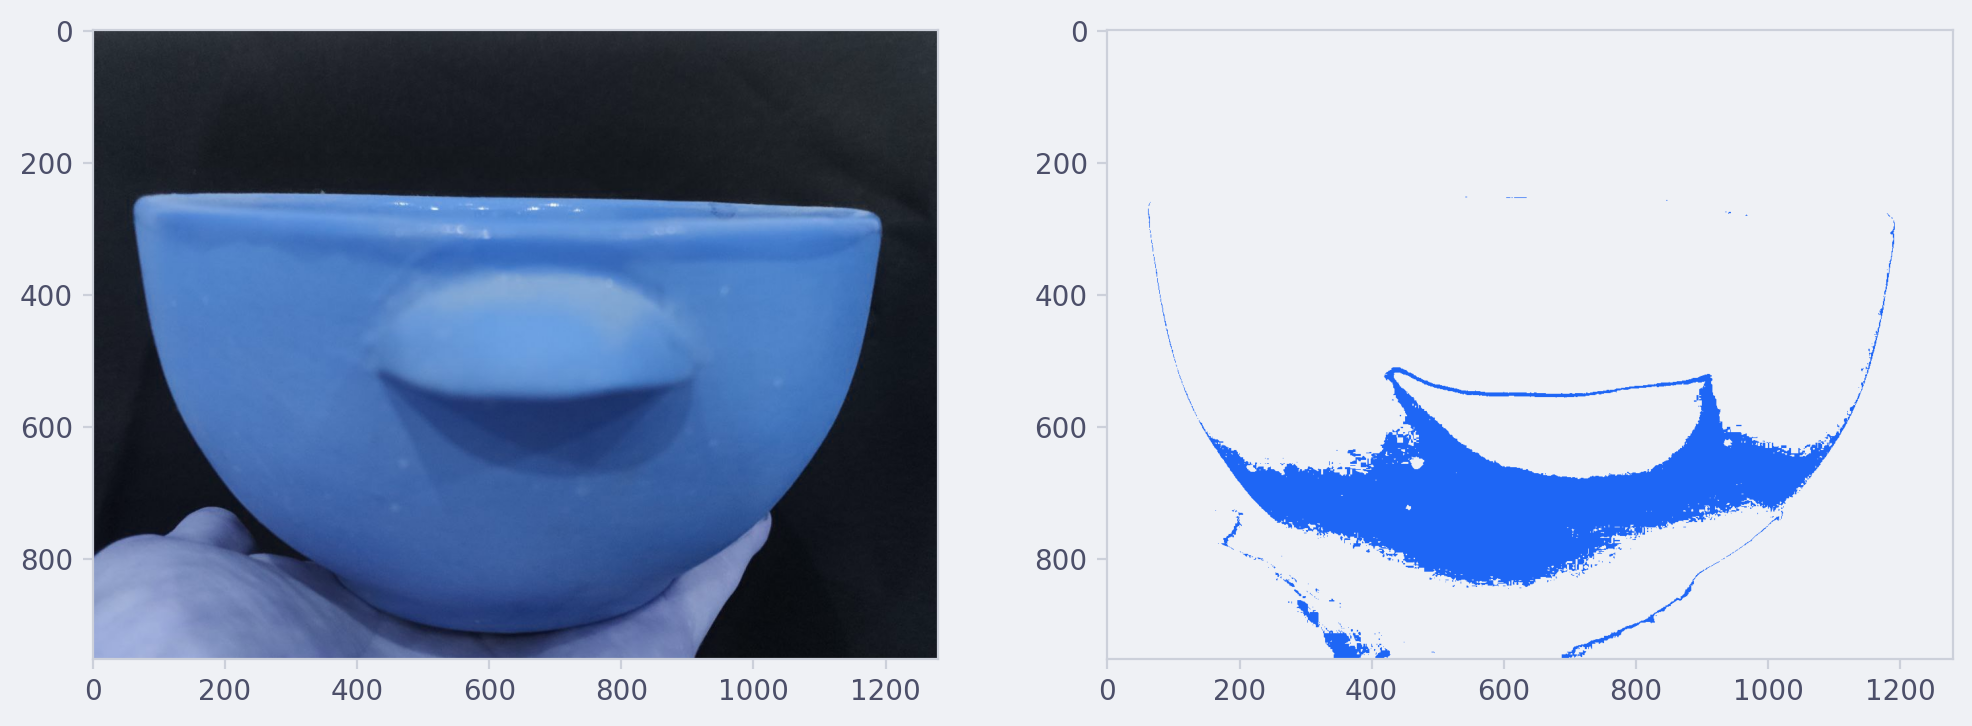

In [16]:
side_view = cv2.imread("side_vid.jpg")
gorshok_color = np.array([69, 97, 163])
gorshok_only_image = (np.linalg.norm(side_view - gorshok_color, ord = 2, axis = 2) < 20).astype('uint8')
fig, ax = plt.subplots(1, 2, figsize = (12, 5), dpi = 200)
ax[0].imshow(side_view)
ax[1].imshow(gorshok_only_image)

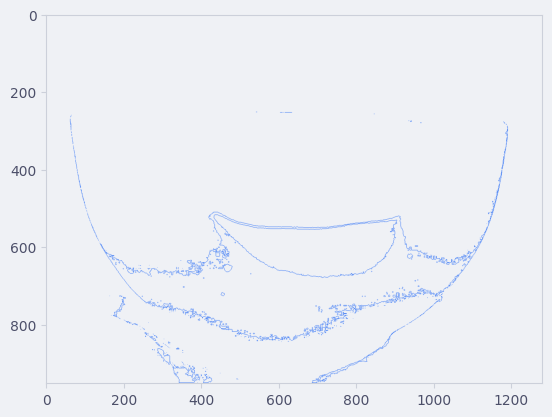

In [17]:
contours, hierarchy = cv2.findContours(gorshok_only_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_contours = np.uint8(np.zeros((gorshok_only_image.shape[0],gorshok_only_image.shape[1])))
cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
plt.imshow(img_contours)

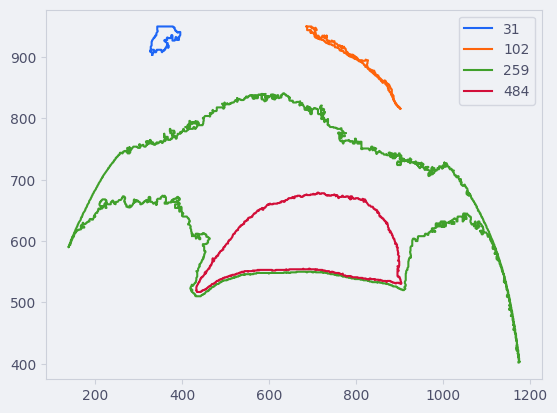

In [18]:
plt.figure()
for ind, cont in enumerate(contours):
    if cont.shape[0] > 100:
        plt.plot(cont[:, 0, 0], cont[:, 0, 1], label = ind)
plt.legend()

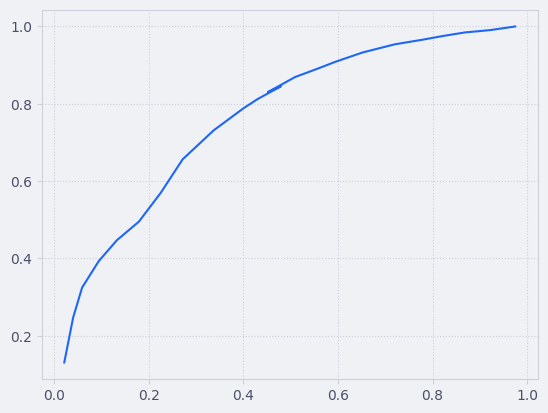

In [19]:
real_shape = pd.read_csv('side_shape.csv')
real_shape.y /= np.max(real_shape.y)
plt.plot(real_shape.x, real_shape.y)
plt.grid(ls = ':')

In [20]:
def get_Z(n: float):
    theta = polarization_degree_to_reflection_angle(res['linear_polarizatioin_degree'], n = n)
    normal_map = np.array([np.sin(theta) * np.cos(res['angle_of_polarization']+ np.pi / 2) / (np.cos(theta) + 1e-6),
                        np.sin(theta) * np.sin(res['angle_of_polarization']+ np.pi / 2) / (np.cos(theta) + 1e-6),
                        np.ones_like(theta)]).T
    normal_map = np.swapaxes(normal_map, 0, 1)
    normal_map /= np.linalg.norm(normal_map, ord = 2, keepdims = True, axis = 2)
    normal_map = (np.cos(theta) > 1e-2)[:, :, np.newaxis] * normal_map
    depth_map = normal_map_least_square_integration(normal_map)
    depth_map /= np.max(np.abs(depth_map))
    mask = res['linear_polarizatioin_degree'] < 1e-2 * 5 
    x, y = np.arange(depth_map.shape[1]), np.arange(depth_map.shape[0])
    X, Y = np.meshgrid(x, y)
    Z = np.copy(depth_map)
    Z[mask] = 0
    black_mask = polarization_135 < 10
    Z[black_mask] = np.min(Z[np.logical_not(black_mask)])
    return gaussian_filter(Z, sigma = 5)

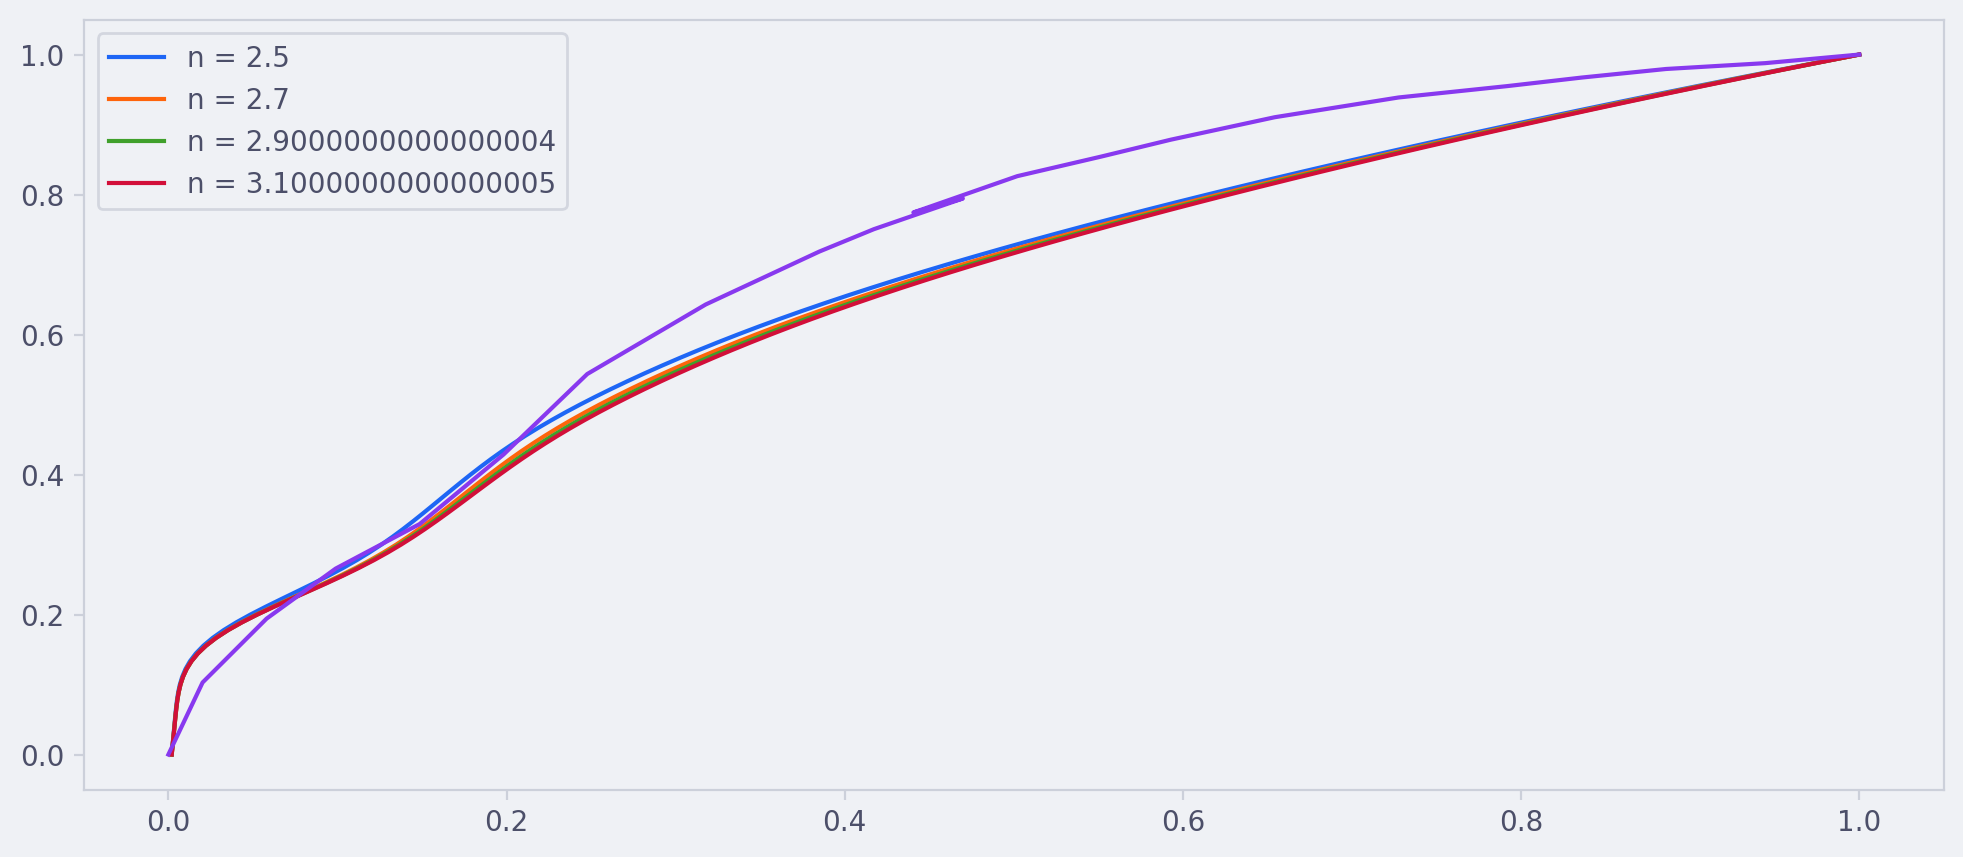

In [21]:
n_values = np.arange(2.5, 3.2, 0.2)
plt.figure(figsize = (12, 5), dpi = 200)
for n in n_values:
    Z = get_Z(n)
    x_max_index = np.where(Z == Z.max())[0][0]
    x_estimated = Z[:, x_max_index][::-1]
    y_estimated = Y[:, x_max_index]
    thresh = 130
    mask = y_estimated < thresh
    x_estimated, y_estimated = x_estimated[mask], y_estimated[mask].astype(np.float64)
    x_estimated += np.abs(np.min(x_estimated))
    x_estimated /= np.max(x_estimated)
    y_estimated /= np.max(y_estimated)
    mask = y_estimated > 0.3 
    x_estimated, y_estimated = x_estimated[mask], y_estimated[mask]
    y_estimated -= np.abs(np.min(y_estimated))
    y_estimated /= np.max(y_estimated)
    plt.plot(x_estimated, y_estimated, label = f'n = {n}')
real_shape.x = real_shape.x[1:]
real_shape.y = real_shape.y[1:]
real_shape.y -= np.min(real_shape.y)
real_shape.y /= np.max(real_shape.y)
real_shape.x -= np.min(real_shape.x)
real_shape.x /= np.max(real_shape.x)
plt.plot(real_shape.x, real_shape.y)
plt.legend()

### Подбор хорошего показателя преломления


In [22]:
def get_Z(n: float):
    theta = polarization_degree_to_reflection_angle(res['linear_polarizatioin_degree'], n = n)
    normal_map = np.array([np.sin(theta) * np.cos(res['angle_of_polarization']+ np.pi / 2) / (np.cos(theta) + 1e-6),
                        np.sin(theta) * np.sin(res['angle_of_polarization']+ np.pi / 2) / (np.cos(theta) + 1e-6),
                        np.ones_like(theta)]).T
    normal_map = np.swapaxes(normal_map, 0, 1)
    normal_map /= np.linalg.norm(normal_map, ord = 2, keepdims = True, axis = 2)
    normal_map = (np.cos(theta) > 1e-2)[:, :, np.newaxis] * normal_map
    depth_map = normal_map_least_square_integration(normal_map)
    depth_map /= np.max(np.abs(depth_map))
    mask = res['linear_polarizatioin_degree'] < 1e-2 * 5 
    x, y = np.arange(depth_map.shape[1]), np.arange(depth_map.shape[0])
    X, Y = np.meshgrid(x, y)
    Z = np.copy(depth_map)
    Z[mask] = 0
    black_mask = polarization_135 < 5
    Z[black_mask] = np.min(Z[np.logical_not(black_mask)])
    return gaussian_filter(Z, sigma = 2), normal_map

In [23]:
from scipy.misc import derivative
from scipy.interpolate import RectBivariateSpline

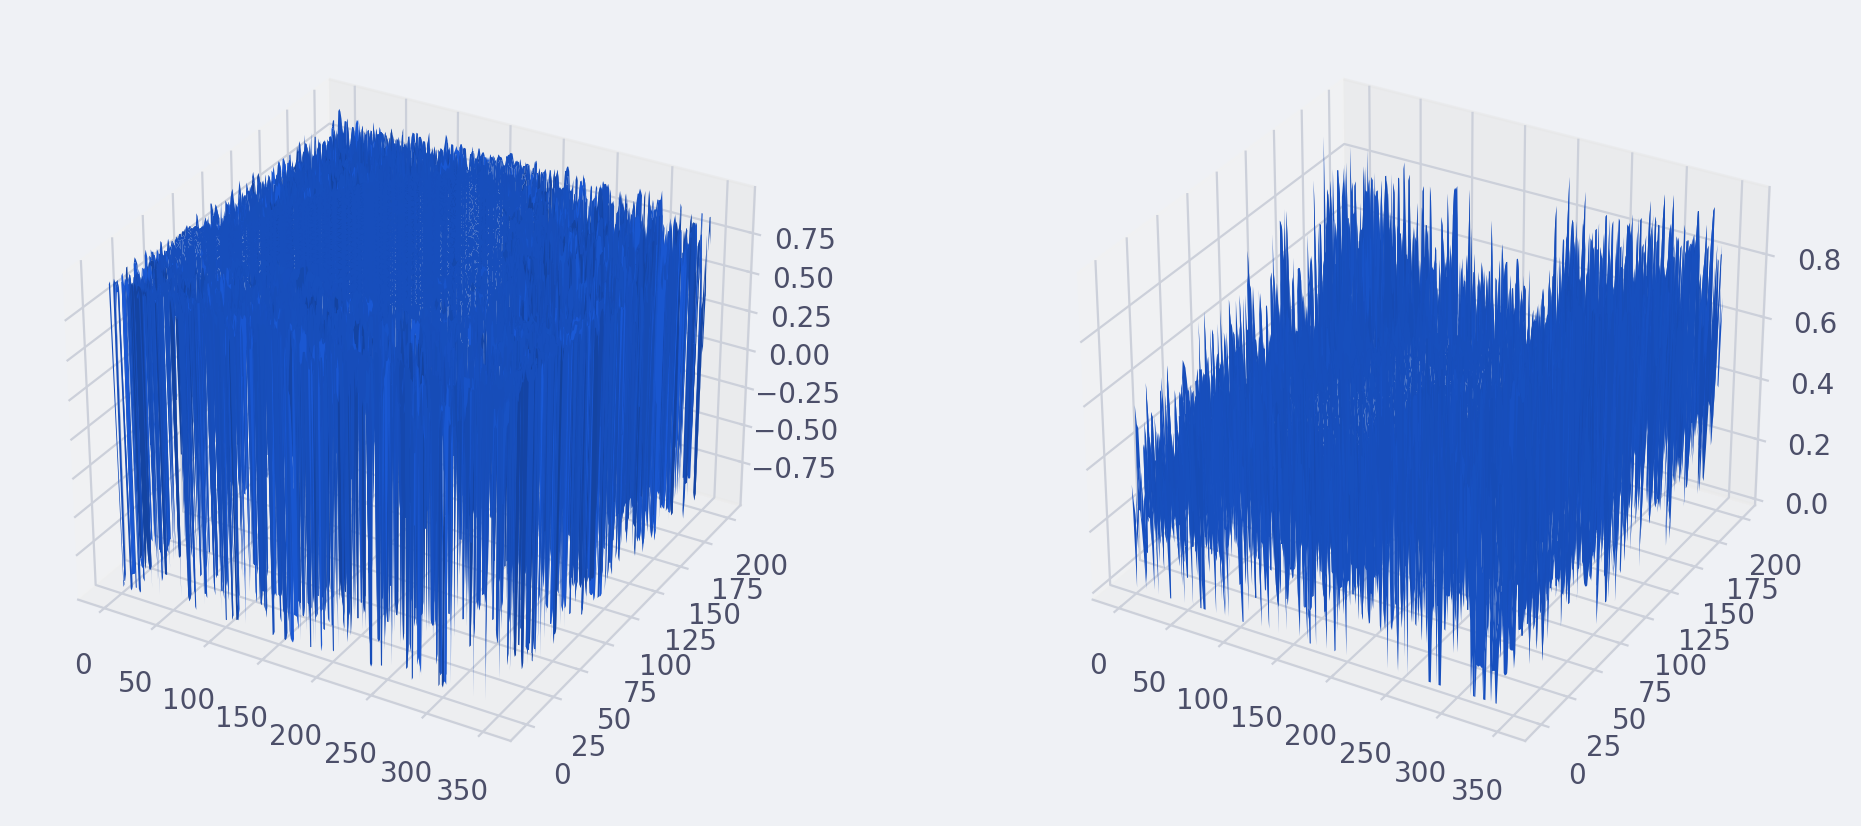

In [24]:
depth_map, normal_map = get_Z(1.6)
p_numerical = normal_map[:, :, 0]
q_numerical = normal_map[:, :, 1]
x, y = np.arange(p_numerical.shape[0]), np.arange(p_numerical.shape[1])
q_functional = RectBivariateSpline(x, y, q_numerical)
p_functional = RectBivariateSpline(x, y, p_numerical)
fig = plt.figure(figsize = (12, 5), dpi = 200)
ax_p = fig.add_subplot(121, projection = '3d')
ax_p.plot_surface(X, Y, p_functional(x, y))
ax_q = fig.add_subplot(122, projection = '3d')
ax_q.plot_surface(X, Y, q_functional(x, y))

In [25]:
def get_error(n):
    depth_map, normal_map = get_Z(n)
    p_numerical = normal_map[:, :, 0]
    q_numerical = normal_map[:, :, 1]
    x, y = np.arange(p_numerical.shape[0]), np.arange(p_numerical.shape[1])
    Z_functional = RectBivariateSpline(x, y, depth_map)
    dZ_dx, dZ_dy = np.zeros_like(depth_map), np.zeros_like(depth_map)
    for x_val in x:
        for y_val in y:
            dZ_dx[x_val - 1, y_val - 1] = derivative(lambda x_param: Z_functional(x_param, y_val),
                                                     x0 = x_val)
            dZ_dy[x_val - 1, y_val - 1] = derivative(lambda y_param: Z_functional(x_val, y_param),
                                                     x0 = y_val)
    return np.sum(np.sum(np.power(dZ_dx + p_numerical, 2) + np.power(dZ_dy + q_numerical, 2)))


In [26]:
# n_values = np.arange(1, 5, 0.1)
# error_values = [get_error(n) for n in n_values]


In [27]:
plt.figure(figsize = (12, 5), dpi = 200)
plt.plot(n_values, error_values / np.max(error_values))
plt.title("Зависимость ошибки от показателя преломления")
plt.xlabel("Показатель преломления n", fontsize = 16)
plt.ylabel("Ошибка", fontsize = 16)
plt.grid(ls = ":")

NameError: name 'error_values' is not defined

<Figure size 2400x1000 with 0 Axes>

https://onlinelibrary.wiley.com/doi/pdf/10.1002/0471473359.app9